<a href="https://colab.research.google.com/github/kiseonjeong/computer-vision/blob/2-study-the-super-resolution-algorithm/super%20resolution/cifar10_espcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def normalize(x):
    return x / 255.0

def denormalize(x):
    return (x + 1) * 127.5

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

light_flag = False

input_kernel = 5
if light_flag is True:
    input_kernel = 1
print('input kernel size:', input_kernel, 'x', input_kernel)

scale_factor = 4

input kernel size: 5 x 5


In [3]:
# Set input layer
inputs = keras.Input(shape=(32, 32, 3), name='img')
x = layers.Lambda(normalize)(inputs)

# Patch extraction layer
x = layers.Conv2D(
    filters=64,
    kernel_size=input_kernel,           # (1x1) : Light ESPCN, (5x5) : ESPCN
    padding='same',
    activation='relu'
)(x)

# Feature extraction layer
x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    padding='same',
    activation='relu'
)(x)

# Up sampling layer (128x128)
x = layers.Conv2D(filters=3 * (scale_factor ** 2), kernel_size=3, padding='same')(x)
x = layers.Lambda(pixel_shuffle(scale_factor))(x)

# Output layer
x = layers.Activation(activation='tanh')(x)
outputs = layers.Lambda(denormalize)(x)

# Set a ESPCN model
model = keras.Model(inputs, outputs, name='ESPCN')
model.summary()

Model: "ESPCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 48)        27696     
                                                                 
 lambda_1 (Lambda)           (None, 128, 128, 3)       0         
                                                                 
 activation (Activation)     (None, 128, 128, 3)       0     

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

170508288/170498071 [==============================] - 11s 0us/step


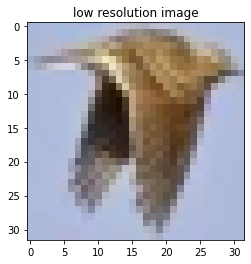

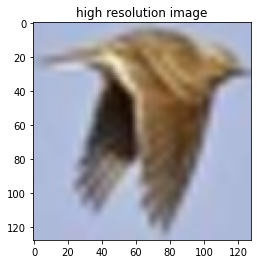

In [5]:
# Load image data
ishape = 128
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Reduce the dataset
train_image = train_images[0:10000]
test_image = test_images[0:1000]

x_train = np.array([img for img in train_image])
x_test = np.array([img for img in test_image])

y_train = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in train_image])
y_test = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in test_image])

# Show an example image
example_idx = 123
plt.figure('LR')
plt.imshow(x_train[example_idx])
plt.title('low resolution image')
plt.figure('HR')
plt.imshow(y_train[example_idx])
plt.title('high resolution image')
plt.show()

In [6]:
# Train the model
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=255.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=255.0)

model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='mse', metrics=[PSNR, SSIM, 'accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)

print('Test loss:', test_scores[0])
print('Test mse:', test_scores[1])

# Save entire model to a HDF5 file
model.save('ESPCN.h5')

Epoch 1/10
125/125 [==============================] - 20s 74ms/step - loss: 3009.6960 - PSNR: 14.1572 - SSIM: 0.4001 - accuracy: 0.4594 - val_loss: 1123.3297 - val_PSNR: 18.0872 - val_SSIM: 0.5163 - val_accuracy: 0.5552
Epoch 2/10
125/125 [==============================] - 8s 68ms/step - loss: 636.1138 - PSNR: 20.7195 - SSIM: 0.6140 - accuracy: 0.6400 - val_loss: 402.0143 - val_PSNR: 22.5142 - val_SSIM: 0.6910 - val_accuracy: 0.6941
Epoch 3/10
125/125 [==============================] - 8s 68ms/step - loss: 342.2234 - PSNR: 23.2948 - SSIM: 0.7229 - accuracy: 0.7249 - val_loss: 278.8294 - val_PSNR: 24.1346 - val_SSIM: 0.7582 - val_accuracy: 0.7518
Epoch 4/10
125/125 [==============================] - 8s 68ms/step - loss: 256.2451 - PSNR: 24.5301 - SSIM: 0.7791 - accuracy: 0.7706 - val_loss: 227.4685 - val_PSNR: 25.0584 - val_SSIM: 0.8023 - val_accuracy: 0.7801
Epoch 5/10
125/125 [==============================] - 8s 67ms/step - loss: 217.4485 - PSNR: 25.2279 - SSIM: 0.8142 - accuracy: 0.

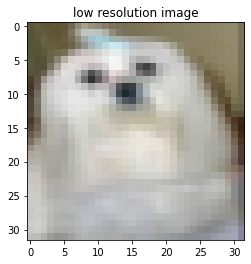

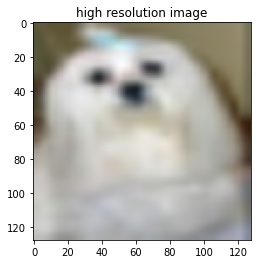

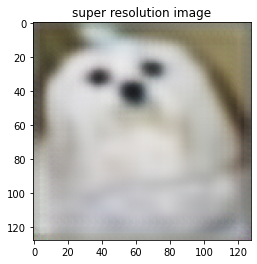

In [7]:
# Set real test image
img = train_images[20001]
lr = np.array(img)
hr = np.array(cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC))
test_input = np.reshape(lr, (1, 32, 32, 3))

# Predict a result
sr = model.predict(test_input)
plt.figure('LR')
plt.title('low resolution image')
plt.imshow(lr)
plt.figure('HR')
plt.title('high resolution image')
plt.imshow(hr)
plt.figure('SR')
plt.title('super resolution image')
plt.imshow(sr[0] / 255.0)
plt.show()